In [1]:
# Import local libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import time

# Import GeoPandas
import geopandas as gpd

# Import PySpark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructField, StructType, StringType, IntegerType, DoubleType, FloatType
from pyspark.sql.functions import col

# Import Apache Sedona
from sedona.register import SedonaRegistrator
from sedona.core.formatMapper.shapefileParser import ShapefileReader
from sedona.utils import SedonaKryoRegistrator, KryoSerializer
from sedona.utils.adapter import Adapter as adp

## Define spark session if not defined yet
No need to define spark if run in an external cloud

In [2]:
try:
    spark
except NameError:
    spark = SparkSession. \
    builder. \
    appName('appName'). \
    master('local[*]'). \
    config("spark.serializer", KryoSerializer.getName). \
    config("spark.kryo.registrator", SedonaKryoRegistrator.getName). \
    config("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    config("spark.hadoop.fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider"). \
    getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/09 09:45:57 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/02/09 09:45:57 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
SedonaRegistrator.registerAll(spark)
sc = spark.sparkContext
sc.setSystemProperty("sedona.global.charset", "utf8")
sc._jsc.hadoopConfiguration().set("fs.s3a.aws.credentials.provider", "org.apache.hadoop.fs.s3a.AnonymousAWSCredentialsProvider")

# Use the prefix in all your DBFS path

If you use DBFS, Databricks requires that all paths must be absolute. You can use the variable below as the prefix for all paths.

In [4]:
from pathlib import Path

PATH_PREFIX= str(Path.home()) + '/' if os.environ.get('ENV_WB', 'false') == 'true' else '/'

print(PATH_PREFIX)

/home/wherobots/


## Load Taxi Pick Up Data to Sedona

In [5]:
zones_rdd = ShapefileReader.readToGeometryRDD(sc, "s3a://wherobots-examples/data/pickup_data/shape_file")
zones_df = adp.toDf(zones_rdd, spark)
zones_df = zones_df.drop("_id")
zones_df = zones_df.rdd.zipWithIndex().toDF()
zones_df = zones_df.select(col("_1.*"), col("_2").alias('ids'))
zones_df = zones_df.withColumn("pickup_count", zones_df.pickup_cou.cast(IntegerType())).drop("pickup_cou")
zones_df.show(5)

23/02/09 09:46:00 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


+--------------------+---+------------+
|            geometry|ids|pickup_count|
+--------------------+---+------------+
|POLYGON ((-74.184...|  0|          92|
|MULTIPOLYGON (((-...|  1|          19|
|POLYGON ((-73.847...|  2|           7|
|POLYGON ((-73.971...|  3|        4519|
|POLYGON ((-74.174...|  4|           2|
+--------------------+---+------------+
only showing top 5 rows



## Pattern Detection
Get equal interval maps statistics of the Sedona DataFrame for the attribute pickup_count. The Sedona DataFrame will be returned with a new attribute named intervals which defines the class of each record. Each interval defines a range.

In [ ]:
from lampy import Patterns
from lampy import SparkRegistration

SparkRegistration.set_spark_session(spark)

In [6]:
pattern_df = Patterns.get_equal_interval_map_statistics(zones_df, "pickup_count", 4)
pattern_df.show(5)

+--------------------+---+------------+-------------------+
|            geometry|ids|pickup_count|          intervals|
+--------------------+---+------------+-------------------+
|POLYGON ((-74.184...|  0|          92|Interval 1 [1:9498)|
|MULTIPOLYGON (((-...|  1|          19|Interval 1 [1:9498)|
|POLYGON ((-73.847...|  2|           7|Interval 1 [1:9498)|
|POLYGON ((-73.971...|  3|        4519|Interval 1 [1:9498)|
|POLYGON ((-74.174...|  4|           2|Interval 1 [1:9498)|
+--------------------+---+------------+-------------------+
only showing top 5 rows



## Visualize the Pattern Class of each Record
Each class is defined by a color

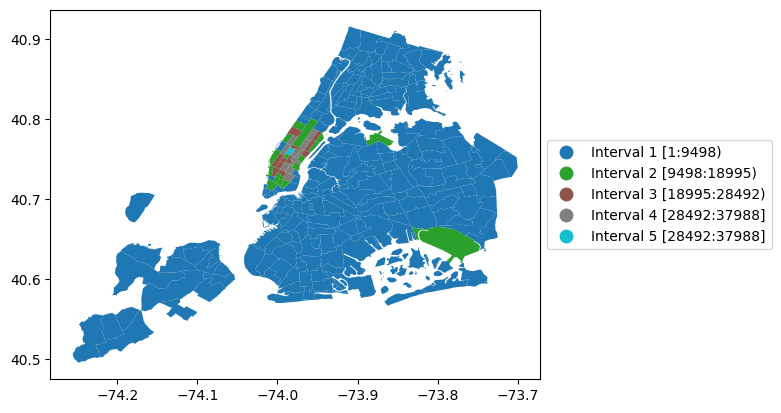

In [7]:
pattern_gdf = gpd.GeoDataFrame(pattern_df.toPandas(), geometry = "geometry", crs = "EPSG:4326")
ax = pattern_gdf.plot(column='intervals', categorical=True, aspect = 'equal', legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})